# This Is a model to classify different types of flowers.
## Most of the things has been explained in this notebbook

#Importing Libraries 

In [1]:
# importing libraries which might be required
import torch as T     #for palying with tensors
import torch.nn as nn       #for using nn.Module while creating own model
import torchvision
import torch.nn.functional as F   #torch module containg activtion functions
import torch.optim as optim       #torch module containing optimizers

import numpy as np
import matplotlib       #for plotting graphs
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns     # for plotting bar graph
import os                 # for getting downloaded data dir
from tqdm.notebook import tqdm    # for showing progress bar while training

# Downloading Dataset


In [2]:
#install opendatasets and importing in colab
!pip install opendatasets
import opendatasets as od

In [3]:
# Downloading dataset from kaggle.com
dataset_url = "https://www.kaggle.com/nunenuh/pytorch-challange-flower-dataset"
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: sankalpsinghbais
Your Kaggle Key: ··········


  0%|          | 0.00/297M [00:00<?, ?B/s]

100%|██████████| 297M/297M [00:04<00:00, 68.9MB/s]


# Arranging and exploring data

In [4]:
#finding current working directory
print(os.getcwd(), os.listdir())

/content ['.config', 'pytorch-challange-flower-dataset', 'sample_data']


In [5]:
#exploring directory and dataset
data_dir = "/content/pytorch-challange-flower-dataset/flower_data"
train_dir = data_dir + "/flower_data/train"
test_dir = data_dir + "/flower_data/valid"      #using validation data as test data
classes = os.listdir(train_dir)
print(len(classes), classes)

102 ['38', '22', '49', '70', '67', '32', '96', '13', '86', '62', '10', '37', '19', '87', '29', '65', '92', '21', '79', '18', '68', '15', '54', '50', '6', '88', '44', '90', '95', '94', '84', '82', '53', '5', '76', '30', '35', '91', '43', '69', '80', '60', '7', '31', '46', '61', '14', '3', '55', '20', '26', '2', '75', '89', '39', '99', '11', '40', '9', '56', '74', '48', '97', '25', '52', '41', '33', '47', '1', '28', '73', '17', '59', '71', '72', '51', '85', '42', '45', '83', '27', '8', '77', '93', '24', '34', '57', '102', '66', '63', '36', '23', '16', '64', '98', '78', '12', '101', '4', '81', '100', '58']


Total no. of classes = total types of flower in dataset = 102

Now the classes above are numeric we are provided with a .json file,
which maps the numbers above the the name of the category



In [6]:
#first lets have a look whats inside the json file
with open (data_dir + "/../cat_to_name.json", 'r') as fi:
  print(fi.read())

{"21": "fire lily", "3": "canterbury bells", "45": "bolero deep blue", "1": "pink primrose", "34": "mexican aster", "27": "prince of wales feathers", "7": "moon orchid", "16": "globe-flower", "25": "grape hyacinth", "26": "corn poppy", "79": "toad lily", "39": "siam tulip", "24": "red ginger", "67": "spring crocus", "35": "alpine sea holly", "32": "garden phlox", "10": "globe thistle", "6": "tiger lily", "93": "ball moss", "33": "love in the mist", "9": "monkshood", "102": "blackberry lily", "14": "spear thistle", "19": "balloon flower", "100": "blanket flower", "13": "king protea", "49": "oxeye daisy", "15": "yellow iris", "61": "cautleya spicata", "31": "carnation", "64": "silverbush", "68": "bearded iris", "63": "black-eyed susan", "69": "windflower", "62": "japanese anemone", "20": "giant white arum lily", "38": "great masterwort", "4": "sweet pea", "86": "tree mallow", "101": "trumpet creeper", "42": "daffodil", "22": "pincushion flower", "2": "hard-leaved pocket orchid", "54": "s

In [7]:
#The output is a dictionary. Lets copy this disctionry to a variable for ease.
import json
with open (data_dir + "/../cat_to_name.json", 'r') as fi:
  cat_to_name_dict = json.load(fi)
print(cat_to_name_dict)

{'21': 'fire lily', '3': 'canterbury bells', '45': 'bolero deep blue', '1': 'pink primrose', '34': 'mexican aster', '27': 'prince of wales feathers', '7': 'moon orchid', '16': 'globe-flower', '25': 'grape hyacinth', '26': 'corn poppy', '79': 'toad lily', '39': 'siam tulip', '24': 'red ginger', '67': 'spring crocus', '35': 'alpine sea holly', '32': 'garden phlox', '10': 'globe thistle', '6': 'tiger lily', '93': 'ball moss', '33': 'love in the mist', '9': 'monkshood', '102': 'blackberry lily', '14': 'spear thistle', '19': 'balloon flower', '100': 'blanket flower', '13': 'king protea', '49': 'oxeye daisy', '15': 'yellow iris', '61': 'cautleya spicata', '31': 'carnation', '64': 'silverbush', '68': 'bearded iris', '63': 'black-eyed susan', '69': 'windflower', '62': 'japanese anemone', '20': 'giant white arum lily', '38': 'great masterwort', '4': 'sweet pea', '86': 'tree mallow', '101': 'trumpet creeper', '42': 'daffodil', '22': 'pincushion flower', '2': 'hard-leaved pocket orchid', '54': 's

# Transforming dataset

In [8]:
from torchvision.datasets import ImageFolder   #used to create a dataset 
import torchvision.transforms as transf   #for transforming image before training


In [9]:
#Traning cant be done with real images. The images are needed to transformed into tensor for training on pytorch
#The data we're using has already been categorised into folder, so we can use ImageFolder method to convert img to tensors
# also lets make the size of all images equal if they are not
img_size = 224      
imagenet_stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])   
transforms = transf.Compose([ 
                            transf.Resize(img_size),      #resizing all image to 224x224
                            transf.Pad(8, padding_mode='reflect'),  #adds space of a 4 units to both side of image 
                            transf.RandomCrop(img_size),  #randomly selects the part of image
                            transf.ToTensor(),            #converting image to tensor
                            transf.Normalize(*imagenet_stats) #normalizes the image
                            ])

dataset = ImageFolder(train_dir, transform = transforms)   #creating the dataset

In [10]:
#Exploring some more......
print("Classes : ",dataset.classes)#dataset classes created by ImageFolder command above
print(f"Total_Classes : {len(dataset.classes)}")
for i in range(10):  #to check dimentions of images
  print(f"Image {i+1} Shape : {dataset[i][0].shape}") 

print("\n\n",dataset) #gives information about the dataset
print(dataset[0][0].dtype)#prints the data type of first image

Classes :  ['1', '10', '100', '101', '102', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '5', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '6', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '7', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '8', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '9', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99']
Total_Classes : 102
Image 1 Shape : torch.Size([3, 224, 224])
Image 2 Shape : torch.Size([3, 224, 224])
Image 3 Shape : torch.Size([3, 224, 224])
Image 4 Shape : torch.Size([3, 224, 224])
Image 5 Shape : torch.Size([3, 224, 224])
Image 6 Shape : torch.Size([3, 224, 224])
Image 7 Shape : torch.Size([3, 224, 224])
Image 8 Shape : torch.Size([3, 224, 224])
Image 9 Shape : torch.Size

So as per above output our data set has 102 types of flowers and each images has three channels thats means the images are RGB , and we have reshaped all images to 224 x 224.

Now lets divide the dataset into two parts train dataset and val dataset.

In [11]:
from torch.utils.data import random_split
train_ds_size = 4914      #using 25 % images out of 6552 image to train 
val_ds_size = len(dataset) - train_ds_size #rest as validation 

train_ds ,val_ds = random_split(dataset,[train_ds_size, val_ds_size]) #randomly distributing images


In [12]:
#lets create a function to show the label and mapped value of label 
del(classes) #deleting variable classes
classes = dataset.classes   #reassigning the varible classes with a list
def mapped_label(labeled_index):
  """
  Pass the label obtained from unpacking  a image and label from a dataset
  img, label = train_ds[20]      <-- pass this single label
  """
  return cat_to_name_dict[str(classes[labeled_index])]

# Exploring Images
Awesome!! since now our image has been rescaled , transformed to tensor, so lets try to have a look over some of the images.


In [13]:
#in tensor form 
img, label = train_ds[4300]
print(label,mapped_label(label), img)
img.shape

44 marigold tensor([[[-1.9295, -1.8782, -1.8268,  ..., -1.8097, -1.8097, -1.8097],
         [-1.8953, -1.8610, -1.7925,  ..., -1.7754, -1.7754, -1.7925],
         [-1.8782, -1.8439, -1.7925,  ..., -1.7583, -1.7583, -1.7754],
         ...,
         [ 1.7694,  1.2214,  0.8618,  ..., -1.8610, -1.8610, -1.8610],
         [ 2.2147,  1.8722,  1.3927,  ..., -1.8439, -1.8610, -1.8610],
         [ 2.1975,  1.9064,  1.7009,  ..., -1.7925, -1.8268, -1.8610]],

        [[-1.8431, -1.7906, -1.7381,  ..., -1.7206, -1.7206, -1.7206],
         [-1.8081, -1.7731, -1.7031,  ..., -1.6856, -1.6856, -1.7031],
         [-1.7906, -1.7556, -1.7031,  ..., -1.6681, -1.6681, -1.6856],
         ...,
         [ 1.4482,  0.8880,  0.5203,  ..., -1.6331, -1.6506, -1.6506],
         [ 1.9384,  1.5182,  1.0455,  ..., -1.6331, -1.6506, -1.6506],
         [ 1.9384,  1.5882,  1.3606,  ..., -1.5980, -1.6331, -1.6506]],

        [[-1.6476, -1.5953, -1.5430,  ..., -1.4907, -1.4907, -1.4907],
         [-1.6127, -1.5779, -1.50

torch.Size([3, 224, 224])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label : 74: rose


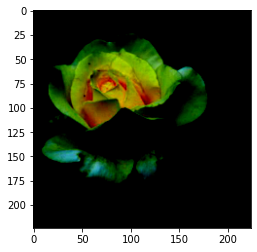

In [14]:
#Since our tensor is of the form (channel, height, width)
#we need to convert it to the form (height, width, channel)
#so that pyplot can display it
#defining a function to do it all
def show_img(ds, ind):     #takes dataset and image index number as input 
  """
  Pass the dataset and the index of the image.
  """
  img, label = ds[ind]      #here image is storing the image but label is storing the index number of the category from the classes.
  cls_ind = dataset.classes[label]
  print(f"Label : {cls_ind}: {mapped_label(label)}")
  plt.imshow(img.permute(1, 2, 0))

show_img(train_ds,2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label : 47: marigold


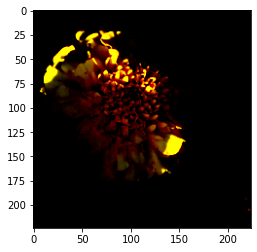

In [15]:
show_img(train_ds, 4300)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label : 20: giant white arum lily


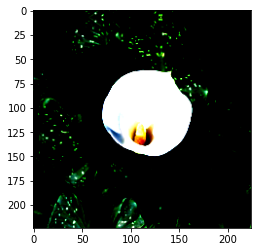

In [16]:
show_img(val_ds, 0)

Lets also have a look over number of images within each class

In [17]:
#the code takes a lil bit long time to run (aprrox 2 min 10 sec)if you wish to run it uncomment all the lines below.
#short cut to uncomment is select all lines below and then ctrl + /

# def img_per_cls(ds):         #select from this line
#   """
#   Warning!!!! Resource Hungry function....
#   Pass the dataset as argument.
#   """  
#   x = []
#   classes = ds.classes
#   for i in range(len(ds)):
#       x.append(ds[i][1])

#   uimg = T.tensor(x).unique(sorted=True)
#   uimg_count = T.stack([(T.tensor(x)==i).sum() for i in uimg])
#   for i in range(len(uimg)):
#       print(f"{classes[i]}, {mapped_label(i)}: {uimg_count[i].item()} count")

# img_per_cls(dataset)


# Creating Dataloaders

In [18]:
#defining data loader sizes
train_dl_size = len(train_ds)
val_dl_size = len(val_ds)
print(f"Train size : {train_dl_size}, Valid Size : {val_dl_size}")

Train size : 4914, Valid Size : 1638


In [19]:
#creating dataloader
from torch.utils.data.dataloader import DataLoader
train_dl = DataLoader(train_ds, batch_size = 63 , shuffle = True,
                      num_workers = 2, pin_memory =True )
val_dl = DataLoader(val_ds, batch_size = 63,num_workers = 2,
                    pin_memory =True )


72 azalea, 30 sweet william, 33 love in the mist, 64 silverbush, 54 sunflower, 77 passion flower, 51 petunia, 50 common dandelion, 83 hibiscus, 10 globe thistle, 52 wild pansy, 54 sunflower, 89 watercress, 39 siam tulip, 80 anthurium, 60 pink-yellow dahlia, 77 passion flower, 30 sweet william, 51 petunia, 38 great masterwort, 2 hard-leaved pocket orchid, 60 pink-yellow dahlia, 38 great masterwort, 53 primula, 84 columbine, 68 bearded iris, 47 marigold, 22 pincushion flower, 75 thorn apple, 32 garden phlox, 44 poinsettia, 52 wild pansy, 95 bougainvillea, 78 lotus lotus, 43 sword lily, 96 camellia, 43 sword lily, 52 wild pansy, 51 petunia, 18 peruvian lily, 2 hard-leaved pocket orchid, 89 watercress, 58 geranium, 73 water lily, 46 wallflower, 19 balloon flower, 81 frangipani, 35 alpine sea holly, 41 barbeton daisy, 85 desert-rose, 31 carnation, 4 sweet pea, 96 camellia, 14 spear thistle, 81 frangipani, 80 anthurium, 6 tiger lily, 78 lotus lotus, 37 cape flower, 60 pink-yellow dahlia, 11 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


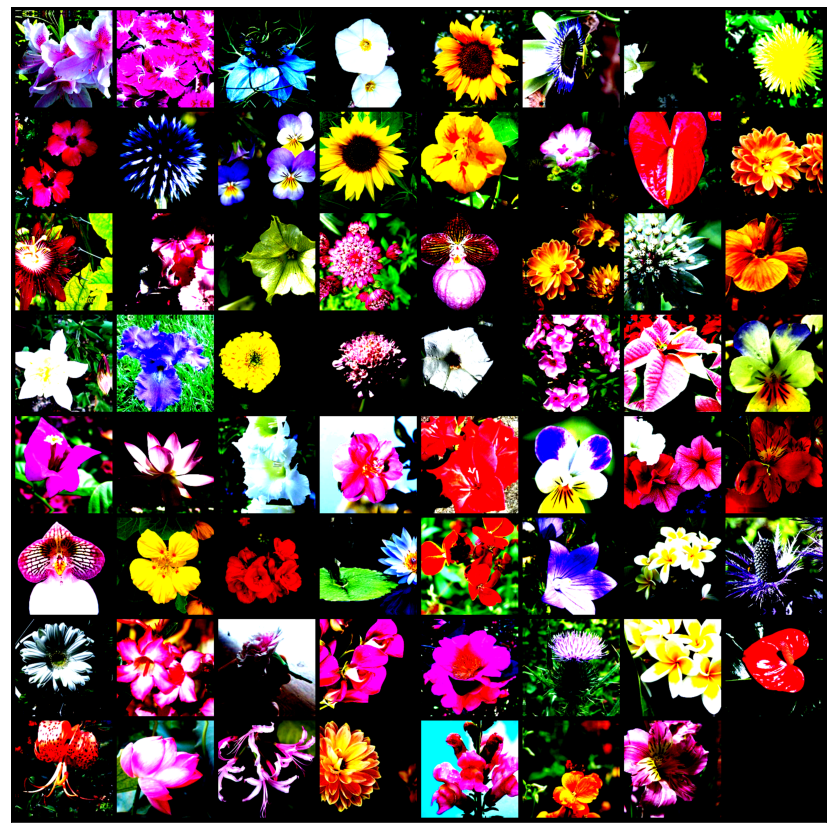

In [20]:
#visualising dataloader batches
from torchvision.utils import make_grid
def disp_batches(dl):
  for img, label in dl:
    for i in label:
      print(dl.dataset.dataset.classes[i],cat_to_name_dict[dl.dataset.dataset.classes[i]], end = ", ") 
    fig, ax = plt.subplots(figsize = (15, 15))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(img, padding = 10).permute(1, 2, 0 ))
    break 

disp_batches(train_dl)


# Creating/Defining Own  Model And Model Methods

Main thing begins here......

In [21]:
#Defining Base model
class Model_Base(nn.Module):
  def training_step(self, batch):
    """
    Passes the training dataloader's batch through Network once and then calculates
    and  returns the loss
    """
    images, labels = batch 
    out = self(images)               # Outputs/Predictions returned by network
    loss = F.cross_entropy(out, labels) # Calculate loss
    return loss

  def validation_step(self, batch):
    """
    Calculates and returns the loss and validation accuracy
    """
    tot_correct = 0
    images, labels = batch 
    out = self(images)                    # Generate predictions
    loss = F.cross_entropy(out, labels)   # Calculate loss
    acc = accuracy(out, labels)           # Calculate accuracy
    tot_correct = get_num_correct(out, labels)    #get total number of corect
    return {"val_loss": loss.detach(), "val_acc": acc, "tot_correct": tot_correct}
      
  def validation_epoch_end(self, outputs):
    """
    Calculate and return validation loss and accuracy after end of each epoch
    """
    tot_correct = 0
    batch_losses = [x['val_loss'] for x in outputs]
    epoch_loss = T.stack(batch_losses).mean()   # Combine losses
    batch_accs = [x['val_acc'] for x in outputs]
    epoch_acc = T.stack(batch_accs).mean()      # Combine accuracies
    tot_correct = sum([x['tot_correct'] for x in outputs])
    return {"val_loss": epoch_loss.item(), "val_acc": epoch_acc.item(), "tot_correct": tot_correct}
  
  def epoch_end(self, epoch, result):
    """
    Calculate and return Training loss after end of each epoch
    """
    print(f"Epoch {epoch+1}, Train loss : {result['train_loss']}, Val. Loss : {result['val_loss']}, val_acc : {result['val_acc']}, Total_Correct : {result['tot_correct']}")
    

In [22]:
#defining neural network model
class Flower_Classification_Model(Model_Base):
  """
  Pass colour channels and total number of classes as an argument.
  The Network consists of 6 Conv2d layers and  4 linear layers
  """
  def __init__(self,input_channels,output_classes):
    self.input_channels = input_channels    
    self.output_classes = output_classes
    
    super().__init__()                         #defining Network layers
    self.network= nn.Sequential(
            
            nn.Conv2d(self.input_channels,64,kernel_size = 3, padding=1),   #conv layer 1  
            nn.ReLU(),        #activation function 
            nn.Conv2d(64,72,kernel_size = 3, padding=1),#conv layer 2
            nn.ReLU(),
            nn.MaxPool2d(2,2),  # 72x 112 x 112          #Exatracting features using max pool

            nn.Conv2d(72, 80, kernel_size=3, stride=1, padding=1),    #conv layer 3
            nn.ReLU(),
            nn.Conv2d(80, 88, kernel_size=3, stride=1, padding=1),    #conv layer 4
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 88 x 56 x 56

            nn.Conv2d(88, 96, kernel_size=3, stride=1, padding=1),      #conv layer 5
            nn.ReLU(),
            nn.Conv2d(96, 104, kernel_size=3, stride=1, padding=1,),    #conv layer 6
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 104 x 28 x 28
            
            nn.Conv2d(104,112, kernel_size=3, stride=1, padding=1),      #conv layer 7
            nn.ReLU(),
            nn.Conv2d(112, 120, kernel_size=3, stride=1, padding=1,),    #conv layer 8
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 120 x 14 x 14
           
            nn.Flatten(),           #Flatting the image tensor to pass it to linear layer
            nn.Linear(in_features = 120*14*14, out_features = output_classes),
    )
    
  def forward(self, t):             #this method is required while creating a model
    return self.network(t)



In [23]:
#defining function to calculate accuracy of the prediction/ output given by the model.
def accuracy(outputs, labels):
    """
    calulates the acuuracy of the model
    """
    _, preds = T.max(outputs, dim=1)
    print("->", end = '')
    return T.tensor(T.sum(preds == labels).item() / len(preds))

In [24]:
def get_num_correct(outputs, labels):
  """
  returns how many predictions were right
  """
  return (outputs.argmax(dim = 1).eq(labels).sum().item())

## Defining Function to train and validate model

In [25]:
@T.no_grad() #turning off pytorch's gradient feature

def evaluate(model, dloader):   
    model.eval()
    outputs = [model.validation_step(batch) for batch in dloader]
    return model.validation_epoch_end(outputs)

def fit(model, train_dloader, val_dloader, epochs = 1, lr = 0.01):
  """
  Takes in model , train dataloader, validation dataloader, epochs, learning rate
  and the trains the model for epoch times with provided learning rate
  """ 
  history = []    #list to store the result after each epoch
  optimizer = optim.Adam(model.parameters(), lr) 
  
  for epoch in range(epochs):
    print(f"Epoch : {epoch+1} of {epochs}:\nTraining ")
    #Training Model
    model.train()   
    train_losses = []
    for batch in tqdm(train_dloader):
      loss = model.training_step(batch)
      train_losses.append(loss)
      optimizer.zero_grad()       
      loss.backward()
      optimizer.step()
    #Validating after each epoch
    print("Validating ")
    result = evaluate(model, val_dloader)
    print("\n\t")
    result["train_loss"] = T.stack(train_losses).mean().item()
    model.epoch_end(epoch, result)
    history.append(result)
  return history


# GPU \ CPU Selection


In [46]:
def get_default_device():
  """Pick CUDA supported GPU if available, else CPU"""
  if T.cuda.is_available():
    T.cuda.empty_cache()    #clearing cache in GPU to get most out of it
    return T.device("cuda")
  else:
    return T.device("cpu")


def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [47]:
device = get_default_device() 
# device = T.device("cpu") 
device

device(type='cuda')

In [48]:
#moving dataloaders to selected device
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

# Training Model


In [49]:
#Moving model to the device and creating instance of the model 
print(device)
input_channel = 3
output_classes = len(classes)
fcmodel =Flower_Classification_Model(input_channel,output_classes)
fcmodel =to_device(fcmodel, device)
print(fcmodel)

cuda
Flower_Classification_Model(
  (network): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 72, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(72, 80, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(80, 88, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(88, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(96, 104, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Conv2d(104, 112, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (16): ReLU()
    (17): Conv2d(112, 120, kernel_size=(3, 

In [50]:
%%time
evaluate(fcmodel, val_dl)

->->->->->->->->->->->->->->->->->->->->->->->->->->CPU times: user 1.25 s, sys: 907 ms, total: 2.16 s
Wall time: 12.1 s


{'tot_correct': 35,
 'val_acc': 0.021367521956562996,
 'val_loss': 4.624234676361084}

The first line above (%%time) is call a magic line
At the end of excution of the cell it returns elapsed time of the execution.

In [51]:
%%time
model = fcmodel
epochs = 40
train_dloader = train_dl
val_dloader = val_dl
lr = 0.00002
history = fit(model, train_dloader, val_dloader,epochs, lr)

Epoch : 1 of 40:
Training 



Validating 
->->->->->->->->->->->->->->->->->->->->->->->->->->
	
Epoch 1, Train loss : 4.567562103271484, Val. Loss : 4.500042915344238, val_acc : 0.026862027123570442, Total_Correct : 44
Epoch : 2 of 40:
Training 



Validating 
->->->->->->->->->->->->->->->->->->->->->->->->->->
	
Epoch 2, Train loss : 4.474708557128906, Val. Loss : 4.39454460144043, val_acc : 0.04395604506134987, Total_Correct : 72
Epoch : 3 of 40:
Training 



Validating 
->->->->->->->->->->->->->->->->->->->->->->->->->->
	
Epoch 3, Train loss : 4.208705902099609, Val. Loss : 3.9084324836730957, val_acc : 0.07203907519578934, Total_Correct : 118
Epoch : 4 of 40:
Training 



Validating 
->->->->->->->->->->->->->->->->->->->->->->->->->->
	
Epoch 4, Train loss : 3.6679880619049072, Val. Loss : 3.510143756866455, val_acc : 0.1367521435022354, Total_Correct : 224
Epoch : 5 of 40:
Training 



Validating 
->->->->->->->->->->->->->->->->->->->->->->->->->->
	
Epoch 5, Train loss : 3.315424919128418, Val. Loss : 3.337820291519165, val_acc : 0.1617826670408249, Total_Correct : 265
Epoch : 6 of 40:
Training 



Validating 
->->->->->->->->->->->->->->->->->->->->->->->->->->
	
Epoch 6, Train loss : 3.0953028202056885, Val. Loss : 3.2355213165283203, val_acc : 0.19658119976520538, Total_Correct : 322
Epoch : 7 of 40:
Training 



Validating 
->->->->->->->->->->->->->->->->->->->->->->->->->->
	
Epoch 7, Train loss : 2.9560117721557617, Val. Loss : 3.1650726795196533, val_acc : 0.222222238779068, Total_Correct : 364
Epoch : 8 of 40:
Training 



Validating 
->->->->->->->->->->->->->->->->->->->->->->->->->->
	
Epoch 8, Train loss : 2.842510461807251, Val. Loss : 3.059999942779541, val_acc : 0.2588522732257843, Total_Correct : 424
Epoch : 9 of 40:
Training 



Validating 
->->->->->->->->->->->->->->->->->->->->->->->->->->
	
Epoch 9, Train loss : 2.7435669898986816, Val. Loss : 2.9507429599761963, val_acc : 0.2710622549057007, Total_Correct : 444
Epoch : 10 of 40:
Training 



Validating 
->->->->->->->->->->->->->->->->->->->->->->->->->->
	
Epoch 10, Train loss : 2.6288511753082275, Val. Loss : 2.983596086502075, val_acc : 0.27228325605392456, Total_Correct : 446
Epoch : 11 of 40:
Training 



Validating 
->->->->->->->->->->->->->->->->->->->->->->->->->->
	
Epoch 11, Train loss : 2.5271155834198, Val. Loss : 2.921241044998169, val_acc : 0.2924298048019409, Total_Correct : 479
Epoch : 12 of 40:
Training 



Validating 
->->->->->->->->->->->->->->->->->->->->->->->->->->
	
Epoch 12, Train loss : 2.4432952404022217, Val. Loss : 2.96614146232605, val_acc : 0.28327229619026184, Total_Correct : 464
Epoch : 13 of 40:
Training 



Validating 
->->->->->->->->->->->->->->->->->->->->->->->->->->
	
Epoch 13, Train loss : 2.3602585792541504, Val. Loss : 2.8087494373321533, val_acc : 0.3174603581428528, Total_Correct : 520
Epoch : 14 of 40:
Training 



Validating 
->->->->->->->->->->->->->->->->->->->->->->->->->->
	
Epoch 14, Train loss : 2.270887851715088, Val. Loss : 2.8101916313171387, val_acc : 0.3125763237476349, Total_Correct : 512
Epoch : 15 of 40:
Training 



Validating 
->->->->->->->->->->->->->->->->->->->->->->->->->->
	
Epoch 15, Train loss : 2.1915950775146484, Val. Loss : 2.777299642562866, val_acc : 0.3144078254699707, Total_Correct : 515
Epoch : 16 of 40:
Training 



Validating 
->->->->->->->->->->->->->->->->->->->->->->->->->->
	
Epoch 16, Train loss : 2.121786117553711, Val. Loss : 2.7986698150634766, val_acc : 0.32600733637809753, Total_Correct : 534
Epoch : 17 of 40:
Training 



Validating 
->->->->->->->->->->->->->->->->->->->->->->->->->->
	
Epoch 17, Train loss : 2.0556461811065674, Val. Loss : 2.687934637069702, val_acc : 0.3431013524532318, Total_Correct : 562
Epoch : 18 of 40:
Training 



Validating 
->->->->->->->->->->->->->->->->->->->->->->->->->->
	
Epoch 18, Train loss : 1.9440895318984985, Val. Loss : 2.7643096446990967, val_acc : 0.3235653340816498, Total_Correct : 530
Epoch : 19 of 40:
Training 



Validating 
->->->->->->->->->->->->->->->->->->->->->->->->->->
	
Epoch 19, Train loss : 1.8911266326904297, Val. Loss : 2.690234422683716, val_acc : 0.35836389660835266, Total_Correct : 587
Epoch : 20 of 40:
Training 



Validating 
->->->->->->->->->->->->->->->->->->->->->->->->->->
	
Epoch 20, Train loss : 1.818127155303955, Val. Loss : 2.6730494499206543, val_acc : 0.36752134561538696, Total_Correct : 602
Epoch : 21 of 40:
Training 



Validating 
->->->->->->->->->->->->->->->->->->->->->->->->->->
	
Epoch 21, Train loss : 1.7755666971206665, Val. Loss : 2.733827590942383, val_acc : 0.3504273593425751, Total_Correct : 574
Epoch : 22 of 40:
Training 



Validating 
->->->->->->->->->->->->->->->->->->->->->->->->->->
	
Epoch 22, Train loss : 1.6967037916183472, Val. Loss : 2.658792495727539, val_acc : 0.3901098966598511, Total_Correct : 639
Epoch : 23 of 40:
Training 



Validating 
->->->->->->->->->->->->->->->->->->->->->->->->->->
	
Epoch 23, Train loss : 1.6339040994644165, Val. Loss : 2.659153938293457, val_acc : 0.39316239953041077, Total_Correct : 644
Epoch : 24 of 40:
Training 



Validating 
->->->->->->->->->->->->->->->->->->->->->->->->->->
	
Epoch 24, Train loss : 1.5762465000152588, Val. Loss : 2.641977310180664, val_acc : 0.3766789138317108, Total_Correct : 617
Epoch : 25 of 40:
Training 



Validating 
->->->->->->->->->->->->->->->->->->->->->->->->->->
	
Epoch 25, Train loss : 1.513636589050293, Val. Loss : 2.700063467025757, val_acc : 0.3559218645095825, Total_Correct : 583
Epoch : 26 of 40:
Training 



Validating 
->->->->->->->->->->->->->->->->->->->->->->->->->->
	
Epoch 26, Train loss : 1.4601953029632568, Val. Loss : 2.7255208492279053, val_acc : 0.3730158805847168, Total_Correct : 611
Epoch : 27 of 40:
Training 



Validating 
->->->->->->->->->->->->->->->->->->->->->->->->->->
	
Epoch 27, Train loss : 1.436888337135315, Val. Loss : 2.695636749267578, val_acc : 0.3748473823070526, Total_Correct : 614
Epoch : 28 of 40:
Training 



Validating 
->->->->->->->->->->->->->->->->->->->->->->->->->->
	
Epoch 28, Train loss : 1.3540140390396118, Val. Loss : 2.8249542713165283, val_acc : 0.3705739378929138, Total_Correct : 607
Epoch : 29 of 40:
Training 



Validating 
->->->->->->->->->->->->->->->->->->->->->->->->->->
	
Epoch 29, Train loss : 1.2658233642578125, Val. Loss : 2.7305517196655273, val_acc : 0.3858363926410675, Total_Correct : 632
Epoch : 30 of 40:
Training 



Validating 
->->->->->->->->->->->->->->->->->->->->->->->->->->
	
Epoch 30, Train loss : 1.2606958150863647, Val. Loss : 2.7871792316436768, val_acc : 0.4017094075679779, Total_Correct : 658
Epoch : 31 of 40:
Training 



Validating 
->->->->->->->->->->->->->->->->->->->->->->->->->->
	
Epoch 31, Train loss : 1.2200076580047607, Val. Loss : 2.711414098739624, val_acc : 0.39438343048095703, Total_Correct : 646
Epoch : 32 of 40:
Training 



Validating 
->->->->->->->->->->->->->->->->->->->->->->->->->->
	
Epoch 32, Train loss : 1.1396241188049316, Val. Loss : 2.7251272201538086, val_acc : 0.4059829115867615, Total_Correct : 665
Epoch : 33 of 40:
Training 



Validating 
->->->->->->->->->->->->->->->->->->->->->->->->->->
	
Epoch 33, Train loss : 1.098250389099121, Val. Loss : 2.7420051097869873, val_acc : 0.4059829115867615, Total_Correct : 665
Epoch : 34 of 40:
Training 



Validating 
->->->->->->->->->->->->->->->->->->->->->->->->->->
	
Epoch 34, Train loss : 1.0940945148468018, Val. Loss : 2.732135772705078, val_acc : 0.41514042019844055, Total_Correct : 680
Epoch : 35 of 40:
Training 



Validating 
->->->->->->->->->->->->->->->->->->->->->->->->->->
	
Epoch 35, Train loss : 1.0480072498321533, Val. Loss : 2.7800490856170654, val_acc : 0.4145299196243286, Total_Correct : 679
Epoch : 36 of 40:
Training 



Validating 
->->->->->->->->->->->->->->->->->->->->->->->->->->
	
Epoch 36, Train loss : 1.0130548477172852, Val. Loss : 2.766054153442383, val_acc : 0.42429792881011963, Total_Correct : 695
Epoch : 37 of 40:
Training 



Validating 
->->->->->->->->->->->->->->->->->->->->->->->->->->
	
Epoch 37, Train loss : 0.9384902715682983, Val. Loss : 2.9000091552734375, val_acc : 0.4175823926925659, Total_Correct : 684
Epoch : 38 of 40:
Training 



Validating 
->->->->->->->->->->->->->->->->->->->->->->->->->->
	
Epoch 38, Train loss : 0.9162383675575256, Val. Loss : 2.8385674953460693, val_acc : 0.3937729299068451, Total_Correct : 645
Epoch : 39 of 40:
Training 



Validating 
->->->->->->->->->->->->->->->->->->->->->->->->->->
	
Epoch 39, Train loss : 0.9208137392997742, Val. Loss : 2.7672595977783203, val_acc : 0.43223443627357483, Total_Correct : 708
Epoch : 40 of 40:
Training 



Validating 
->->->->->->->->->->->->->->->->->->->->->->->->->->
	
Epoch 40, Train loss : 0.8747316002845764, Val. Loss : 2.906343460083008, val_acc : 0.4377289414405823, Total_Correct : 717
CPU times: user 1min 43s, sys: 1min 2s, total: 2min 46s
Wall time: 30min 38s


The accuracy of our custom model is 43.7% after 40 epochs with some distrotion.
execution time was 30 minutes

lets see accuracy and losses graphically

##Plotting Accuracies and Losses

In [52]:
def plot_accuracies(history):
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title('Accuracy vs. No. of epochs');
    accuracies = [x["val_acc"] for x in history]
    plt.plot(accuracies, '-x')

def plot_losses(history):
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.title("Loss vs. No. of epochs")
    train_losses = [x.get("train_loss") for x in history]
    val_losses = [x["val_loss"] for x in history]
    plt.plot(train_losses, "-bx")
    plt.plot(val_losses, "-rx")
    plt.legend(["Training", "Validation"])



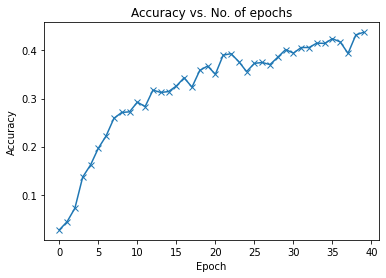

In [53]:
plot_accuracies(history)

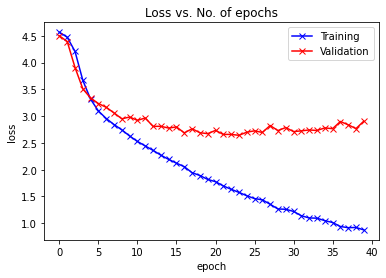

In [54]:
plot_losses(history)

In [55]:
T.save(fcmodel.state_dict(), "flwrclassification-40epo.pth")

#Testing model accuracy on test dataset

In [56]:
#validating model using test_dl
test_ds = ImageFolder(test_dir, transform = transforms) 
test_dl = DeviceDataLoader(DataLoader(test_ds, batch_size = 102), device)

In [57]:
len(test_ds)

818

In [58]:
evaluate(fcmodel, test_dl)

->->->->->->->->->

{'tot_correct': 352,
 'val_acc': 0.3834422826766968,
 'val_loss': 2.8641252517700195}

The accuracy of custom model is 38 percent on test dataset



In [59]:
def upload_image():
  """
  uploades image from the local system and return the image as PIL
  """
  from google.colab import files
  import matplotlib.image as mpimg
  from PIL import Image
  uploaded = files.upload()
  uploaded.keys()
  for x in uploaded.keys():
    path = "/content/"+x
    break
  print(path)
  img = Image.open(path)
  return img
img = upload_image()

Saving rose.jpg to rose.jpg
/content/rose.jpg


In [60]:
def predict_image(img, model, top_num = 5):
    img = transforms(img)
    xb = to_device(img.unsqueeze(0), device)  #converting into a single batch
    yb = model(xb)            # Get predictions from model
    preds  = (yb)    # Pick index with highest probability
    top_preds, top_labels = preds.topk(top_num)   #get top 5 predictions
    top_preds = top_preds.detach().tolist()[0]     #convert them to list
    top_labels = top_labels.detach().tolist()[0]
    top_flowers = [mapped_label(label) for label in top_labels]    
    return top_preds,top_labels,top_flowers

In [61]:
print(predict_image(img, fcmodel))

([-14.316224098205566, -15.127019882202148, -15.612123489379883, -15.8894624710083, -18.593402862548828], [27, 98, 84, 38, 5], ['carnation', 'camellia', 'hibiscus', 'barbeton daisy', 'snapdragon'])


In [62]:
def plot_pred(img, model, top_num = 5):
    #Get Predictions
    preds, labs, flowers = predict_image(img, model, top_num) 
    #Set up plot
    plt.figure(figsize = (6,10))
    plt.subplot(2,1,1)
    plt.title(flowers[0])
    # Make prediction
    plt.imshow(img)
    # # Plot bar chart
    plt.subplot(2,1,2)
    plt.title("Top Predictions")
    sns.barplot(x=preds, y=flowers, color=sns.color_palette()[0]);
    plt.show()
    print(f"The flower is Probably {dataset.classes[labs[0]],flowers[0]}")

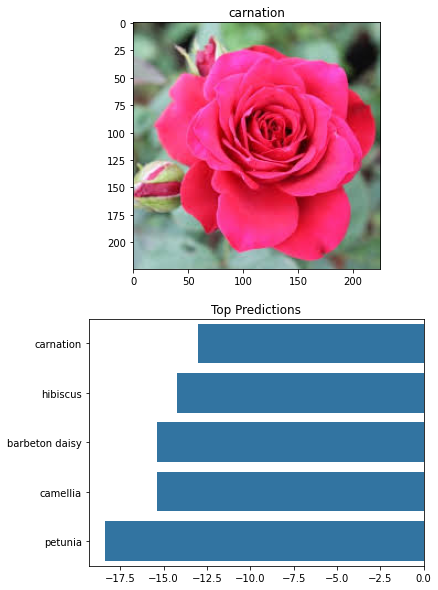

The flower is Probably ('31', 'carnation')


In [64]:
plot_pred(img, fcmodel)

As expected due bad accuracy all the 5 predictions of the model are wrong.
it requires some more training with change in hyper parameters

#Using a pre-trained model for classification 

In [65]:
from torchvision import models

In [74]:
#defing class for pretrained model
class PreTrainedClassificationModel(Model_Base):
  def __init__(self, output_classes, pretrained = True):
    super().__init__()
    self.network = models.resnet34(pretrained = pretrained)
    self.network.fc = nn.Linear(self.network.fc.in_features, output_classes)   #replacing last layer of the pretrained model

  def forward(self, xb):
    return self.network(xb)


In [67]:
def get_lr(optimizer):
  for param_group in optimizer.param_groups:
    return param_group["lr"]


In [68]:
def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader,
                  weight_decay=0, grad_clip=None, opt_func=optim.SGD):
    if T.cuda.is_available():
      T.cuda.empty_cache()
    
    history = []
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)# Set up custom optimizer with weight decay
    
    sched = T.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs,
                                                steps_per_epoch=len(train_loader))    # Set up one-cycle learning rate scheduler
    
    for epoch in range(epochs):
        print(f"Epoch : {epoch+1} of {epochs}:\nTraining")
        # Training Phase
        model.train()
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        # Validation phase
        print("\nValidating ")
        result = evaluate(model, val_loader)
        print("\n\t")
        result['train_loss'] = T.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

##Tuning Pretrained Model

In [75]:
output_classes = len(dataset.classes)
print(output_classes)
fcmodel2 = PreTrainedClassificationModel(output_classes,pretrained = True)
fcmodel2 = to_device(fcmodel2, device)
print(fcmodel2)   #to see models architecture

102
PreTrainedClassificationModel(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0

Let's check the accuracy before tuning


In [76]:
%%time
history2 = [evaluate(fcmodel2, val_dl)]
print(history2)

->->->->->->->->->->->->->->->->->->->->->->->->->->[{'val_loss': 4.918607234954834, 'val_acc': 0.007326007820665836, 'tot_correct': 12}]
CPU times: user 819 ms, sys: 537 ms, total: 1.36 s
Wall time: 11.6 s


Training the resnet34 model to identify data as per our needs

In [77]:
epochs = 10
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = optim.Adam

In [78]:
%%time
history2 += fit_one_cycle(epochs, max_lr, fcmodel2, train_dl, val_dl,
                          grad_clip=grad_clip, weight_decay=weight_decay,
                          opt_func = opt_func)

Epoch : 1 of 10:
Training




Validating 
->->->->->->->->->->->->->->->->->->->->->->->->->->
	
Epoch 1, Train loss : 1.8736412525177002, Val. Loss : 6.946482181549072, val_acc : 0.14529913663864136, Total_Correct : 238
Epoch : 2 of 10:
Training




Validating 
->->->->->->->->->->->->->->->->->->->->->->->->->->
	
Epoch 2, Train loss : 2.383558750152588, Val. Loss : 7.000977516174316, val_acc : 0.160561665892601, Total_Correct : 263
Epoch : 3 of 10:
Training




Validating 
->->->->->->->->->->->->->->->->->->->->->->->->->->
	
Epoch 3, Train loss : 1.9479068517684937, Val. Loss : 3.0207314491271973, val_acc : 0.35164836049079895, Total_Correct : 576
Epoch : 4 of 10:
Training




Validating 
->->->->->->->->->->->->->->->->->->->->->->->->->->
	
Epoch 4, Train loss : 1.2968961000442505, Val. Loss : 2.030252695083618, val_acc : 0.5030525326728821, Total_Correct : 824
Epoch : 5 of 10:
Training




Validating 
->->->->->->->->->->->->->->->->->->->->->->->->->->
	
Epoch 5, Train loss : 0.919505774974823, Val. Loss : 1.6393533945083618, val_acc : 0.5873016119003296, Total_Correct : 962
Epoch : 6 of 10:
Training




Validating 
->->->->->->->->->->->->->->->->->->->->->->->->->->
	
Epoch 6, Train loss : 0.6462797522544861, Val. Loss : 1.055501937866211, val_acc : 0.708791196346283, Total_Correct : 1161
Epoch : 7 of 10:
Training




Validating 
->->->->->->->->->->->->->->->->->->->->->->->->->->
	
Epoch 7, Train loss : 0.4004979133605957, Val. Loss : 0.6292619705200195, val_acc : 0.8162393569946289, Total_Correct : 1337
Epoch : 8 of 10:
Training




Validating 
->->->->->->->->->->->->->->->->->->->->->->->->->->
	
Epoch 8, Train loss : 0.20121198892593384, Val. Loss : 0.36766088008880615, val_acc : 0.8949938416481018, Total_Correct : 1466
Epoch : 9 of 10:
Training




Validating 
->->->->->->->->->->->->->->->->->->->->->->->->->->
	
Epoch 9, Train loss : 0.07862719893455505, Val. Loss : 0.29787442088127136, val_acc : 0.9151403903961182, Total_Correct : 1499
Epoch : 10 of 10:
Training




Validating 
->->->->->->->->->->->->->->->->->->->->->->->->->->
	
Epoch 10, Train loss : 0.04621998965740204, Val. Loss : 0.2880733013153076, val_acc : 0.9181929230690002, Total_Correct : 1504
CPU times: user 1min 10s, sys: 38.5 s, total: 1min 49s
Wall time: 8min 16s


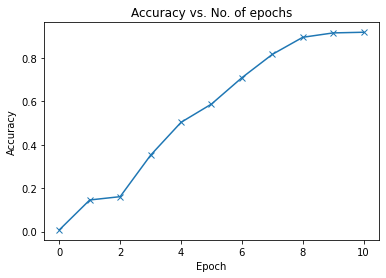

In [79]:
plot_accuracies(history2)

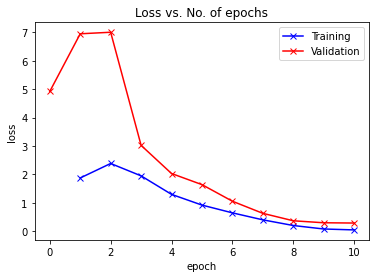

In [80]:
plot_losses(history2)

Final evaluation

In [81]:
evaluate(fcmodel2,test_dl)

->->->->->->->->->

{'tot_correct': 752,
 'val_acc': 0.9281045198440552,
 'val_loss': 0.2897782623767853}

In [82]:
img = upload_image()

Saving rose.jpg to rose (1).jpg
/content/rose.jpg


In [83]:
predict_image(img, fcmodel2)

([12.555598258972168,
  5.566957473754883,
  4.47967529296875,
  3.6242716312408447,
  3.3881916999816895],
 [74, 98, 27, 81, 97],
 ['rose', 'camellia', 'carnation', 'anthurium', 'bougainvillea'])

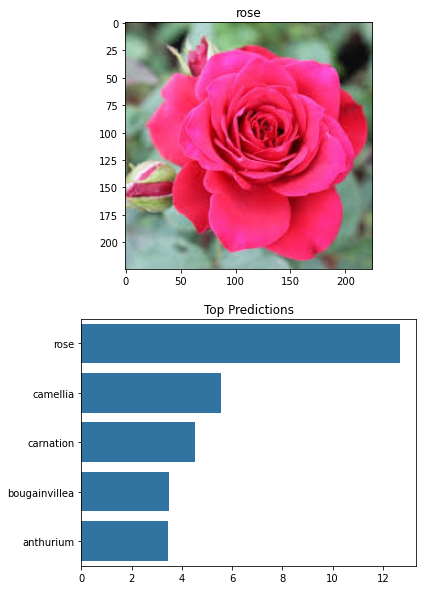

The flower is Probably ('74', 'rose')


In [84]:
plot_pred(img, fcmodel2)

while custom model took 30 mins to train for 40 epochs and gave only 38.34% accuracy on test data , the resnet34 model gave 92% accuracy on same test data , and it just took 10 epochs and less than 10 minutes